In [2]:
import os
import pandas as pd
import numpy as np
import pprint

# =============================================================================
# BLOCO 1: CONFIGURAÇÃO, CARREGAMENTO, DIVISÃO (80/20) E SEGMENTAÇÃO (CORRIGIDO)
# =============================================================================

# --- 1. CONFIGURAÇÕES GERAIS ---
caminho_raiz = r'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset' # IMPORTANTE: Verifique se este caminho está correto
params_drive_end = {'n': 9, 'd': 0.3126, 'D': 1.537, 'phi_graus': 0.0}
TAXA_AMOSTRAL = 12000

# Dicionários de mapeamento
mapa_tipo_falha = {'IR': 'Pista Interna', 'B': 'Esfera', 'OR': 'Pista Externa', 'Normal': 'Normal'}
mapa_diametro_falha = {'7': '0.007"', '14': '0.014"', '21': '0.021"'}

# --- PARÂMETROS DE SEGMENTAÇÃO ---
tamanho_segmento = 4096
sobreposicao_percentual = 0.3
passo = int(tamanho_segmento * (1 - sobreposicao_percentual))

# --- 2. CARREGAMENTO, DIVISÃO E PROCESSAMENTO ---
dicionario_treino = {} # Dicionário para 80% dos dados normais
dicionario_teste = {} # Dicionário para 20% normais + 100% falhas reais

print(f"Iniciando a leitura e segmentação dos arquivos em '{caminho_raiz}'...")
print("Dados normais serão divididos (80% treino / 20% teste).")
print("Dados de falha real irão 100% para o teste.")

# Função auxiliar para segmentar um sinal e adicionar ao dicionário
def segmentar_e_adicionar(sinal, metadados, dicionario_alvo, chave_base):
    # Verifica se o sinal é longo o suficiente para pelo menos um segmento
    if len(sinal) < tamanho_segmento:
        # print(f"Aviso: Sinal da base '{chave_base}' muito curto ({len(sinal)} amostras) para gerar segmentos. Ignorando.")
        return 0

    num_segmentos_criados = 0
    for i, inicio in enumerate(range(0, len(sinal) - tamanho_segmento + 1, passo)):
        segmento = sinal[inicio : inicio + tamanho_segmento]
        df_segmento = pd.DataFrame({'amplitude': segmento})

        # Adiciona metadados
        df_segmento['arquivo_origem'] = metadados['nome_arquivo']
        df_segmento['rotacao_rpm'] = metadados['rpm']
        df_segmento['tipo_falha'] = metadados['tipo_falha']
        df_segmento['diametro_falha'] = metadados['diametro_falha']
        df_segmento['local_sensor'] = 'Drive End'

        chave_segmento = f"{chave_base}_seg_{i}"
        dicionario_alvo[chave_segmento] = df_segmento
        num_segmentos_criados += 1
    return num_segmentos_criados

# Loop principal pelos arquivos
for pasta_atual, _, arquivos in os.walk(caminho_raiz):
    for nome_arquivo in arquivos:
        # Processar apenas arquivos .npz
        if nome_arquivo.endswith('.npz'):
            caminho_completo = os.path.join(pasta_atual, nome_arquivo)

            # Decodificação de metadados
            nome_sem_ext = nome_arquivo.replace('.npz', '')
            partes = nome_sem_ext.split('_')
            rpm_str = partes[0]
            is_normal = 'Normal' in nome_arquivo

            metadados = {
                'nome_arquivo': nome_arquivo,
                'rpm': int(rpm_str) if rpm_str.isdigit() else 0,
                'tipo_falha': 'Normal' if is_normal else mapa_tipo_falha.get(partes[1].split('@')[0], 'Desconhecido'),
                'diametro_falha': 'N/A' if is_normal else mapa_diametro_falha.get(partes[2], 'Desconhecido')
            }

            try:
                dados_npz = np.load(caminho_completo)
                sensor_cod = 'DE' # Foco apenas no Drive End, como no seu código original

                if sensor_cod in dados_npz.files:
                    sinal_completo = dados_npz[sensor_cod].ravel()

                    if is_normal:
                        # DIVIDE O SINAL NORMAL EM 80/20
                        ponto_corte = int(len(sinal_completo) * 0.8)
                        sinal_treino = sinal_completo[:ponto_corte]
                        sinal_teste = sinal_completo[ponto_corte:]

                        chave_base_normal = f"{nome_sem_ext}_{sensor_cod}"
                        segmentar_e_adicionar(sinal_treino, metadados, dicionario_treino, f"{chave_base_normal}_treino")
                        segmentar_e_adicionar(sinal_teste, metadados, dicionario_teste, f"{chave_base_normal}_teste")

                    else:
                        # Sinais com falha (REAIS) vão inteiramente para o TESTE
                        # Lógica de chave para arquivos de falha (igual ao seu original)
                        partes_chave = nome_sem_ext.split('_')
                        partes_chave[-1] = partes_chave[-1].rstrip('0123456789')
                        chave_base_falha = "_".join(partes_chave)
                        
                        # =================================================================
                        # MUDANÇA PRINCIPAL AQUI: Envia falhas reais para o dicionario_teste
                        # =================================================================
                        segmentar_e_adicionar(sinal_completo, metadados, dicionario_teste, chave_base_falha)

            except Exception as e:
                print(f"Erro ao processar o arquivo {nome_arquivo}: {e}")

# --- Relatório Final (Atualizado para refletir a nova lógica) ---
print("\n--- Processo Concluído! ---")
print(f"Total de segmentos de TREINO (APENAS 80% normais): {len(dicionario_treino)}")
print(f"Total de segmentos de TESTE (falhas reais + 20% normais): {len(dicionario_teste)}")

if not dicionario_teste:
    print("\nAVISO: O dicionário de teste está vazio. Verifique se os arquivos 'Normal' existem e se os sinais são longos o suficiente.")

if dicionario_treino:
    # Garante que dicionário não está vazio antes de tentar acessar
    if len(dicionario_treino) > 0:
        chave_exemplo_treino = list(dicionario_treino.keys())[0]
        print(f"\nExemplo de um segmento de TREINO (chave: '{chave_exemplo_treino}'):")
        print(dicionario_treino[chave_exemplo_treino].head())
    else:
        print("\nO dicionário de TREINO está vazio.")

if dicionario_teste:
     # Garante que dicionário não está vazio antes de tentar acessar
    if len(dicionario_teste) > 0:
        chave_exemplo_teste = list(dicionario_teste.keys())[0]
        print(f"\nExemplo de um segmento de TESTE (chave: '{chave_exemplo_teste}'):")
        print(dicionario_teste[chave_exemplo_teste].head())
    else:
        print("\nO dicionário de TESTE está vazio.")

Iniciando a leitura e segmentação dos arquivos em 'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 2897

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE 

In [8]:
# (NOVO) Imports adicionados para plotagem
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# BLOCO 2: GERAÇÃO DE DADOS SINTÉTICOS (USANDO APENAS DADOS DE TREINO)
# =============================================================================

# --- 1. FUNÇÃO PARA CÁLCULO DE FREQUÊNCIA TEÓRICA ---
def calcular_frequencias_rolamento(n, fr, d, D, phi_graus=0.0):
    """Calcula as frequências teóricas de falha de um rolamento."""
    phi_rad = np.deg2rad(phi_graus)
    termo_comum = (d / D) * np.cos(phi_rad)
    return {
        'Pista Externa': (n * fr / 2) * (1 - termo_comum),
        'Pista Interna': (n * fr / 2) * (1 + termo_comum),
        'Esfera': (D * fr / (2 * d)) * (1 - termo_comum**2)
    }

# --- 2. PARÂMETROS DE GERAÇÃO ---
amplitudes_referencia = {
    'Drive End': {'Esfera': 0.0001, 'Pista Interna': 0.001, 'Pista Externa': 0.0001}
}
multiplicadores = [1, 5, 10]
fases_para_adicionar_rad = [
    0, np.pi/2,
    np.pi, 3*np.pi/2
]

# --- 3. IDENTIFICAÇÃO DOS SEGMENTOS NORMAIS DE TREINO ---
# Usamos apenas os dados normais do dicionário de TREINO
segmentos_normais_treino = {
    chave: df for chave, df in dicionario_treino.items()
    if df['tipo_falha'].iloc[0] == 'Normal'
}
print(f"Usando {len(segmentos_normais_treino)} segmentos normais de TREINO para gerar dados sintéticos.")

# =============================================================================
# BLOCO 2: GERAÇÃO DE DADOS SINTÉTICOS (USANDO APENAS DADOS DE TREINO)
# =============================================================================

# ... (O início do Bloco 2, incluindo as funções e parâmetros, permanece o mesmo) ...
# ... (Até a identificação dos segmentos normais de treino) ...

# --- 4. GERAÇÃO E COMBINAÇÃO DOS SINAIS ---
lista_sinais_treino = []

# (NOVO) --- PARÂMETROS PARA O MODELO DE WHITE (Eq. 9 / Fig. 5) ---

# 1. Frequência Natural (f_n ou omega_0 no paper):
#    Baseado nos seus plots de FFT dos dados reais (a "montanha").
freq_natural_hz = 2800  # <--- ESTE É O PARÂMETRO MAIS IMPORTANTE. AJUSTE (ex: 2500, 3000)

# 2. Taxa de Amortecimento (zeta ou ζ no paper):
#    Controla a rapidez com que o "ringing" desaparece.
#    A Figura 5 usa ζ = 0.1[cite: 139]. É um bom ponto de partida.
damping_ratio = 0.1

# (NOVO) --- FUNÇÃO PARA CRIAR A RESPOSTA AO IMPULSO (Decaying Sinusoid) ---
def criar_resposta_impulso(taxa_amostral, freq_natural, damping):
    """
    Cria um único pulso de sinusoide amortecida (baseado na Eq. 9 de White).
    """
    # Duração do pulso (tempo para decair)
    duracao_pulso_seg = 0.05 # 50 ms
    n_pontos_pulso = int(duracao_pulso_seg * taxa_amostral)
    t_pulse = np.linspace(0, duracao_pulso_seg, n_pontos_pulso, endpoint=False)
    
    # Parâmetros da Equação 9 
    A = damping * 2 * np.pi * freq_natural
    # Frequência amortecida (omega_d)
    omega_d = 2 * np.pi * freq_natural * np.sqrt(1 - damping**2)
    
    # Gera o pulso (sinusoide amortecida)
    pulso = np.exp(-A * t_pulse) * np.sin(omega_d * t_pulse)
    
    return pulso

# Cria o pulso de resposta UMA VEZ (ele é o mesmo para todas as falhas)
resposta_impulso_unitaria = criar_resposta_impulso(TAXA_AMOSTRAL, freq_natural_hz, damping_ratio)
# Normaliza para que a amplitude seja controlada pelos parâmetros 'amp_ref' e 'mult'
resposta_impulso_unitaria /= np.max(np.abs(resposta_impulso_unitaria))

print(f"Modelo de White (Eq. 9) ativado. Freq. Natural: {freq_natural_hz} Hz, Amortecimento: {damping_ratio}")

# Loop para gerar os sinais com falha sintética a partir dos normais de treino
for chave_normal, df_normal in segmentos_normais_treino.items():
    sinal_normal_base = df_normal['amplitude'].values
    rpm_atual = df_normal['rotacao_rpm'].iloc[0]
    
    N_PONTOS = len(sinal_normal_base)
    duracao_s = N_PONTOS / TAXA_AMOSTRAL
    t = np.linspace(0.0, duracao_s, N_PONTOS, endpoint=False)
    
    fr_hz = rpm_atual / 60
    freqs_teoricas = calcular_frequencias_rolamento(fr=fr_hz, **params_drive_end)
    
    for tipo_falha_sintetica in ['Pista Externa', 'Pista Interna', 'Esfera']:
        freq_teorica = freqs_teoricas[tipo_falha_sintetica] # Esta é a f_falha (~100-160 Hz)
        amp_ref = amplitudes_referencia['Drive End'][tipo_falha_sintetica]

        # ==========================================================
        # *** LÓGICA DE SIMULAÇÃO NOVA (BASEADA EM WHITE) ***
        
        # 1. Crie o TREM DE IMPULSOS (os "gatilhos" da falha)
        trem_de_impulsos = np.zeros(N_PONTOS)
        periodo_falha_seg = 1.0 / freq_teorica
        ts_segundos = 1.0 / TAXA_AMOSTRAL # tempo de cada amostra
        
        # Adiciona um '1' em cada local de impacto
        for t_impacto in np.arange(0, duracao_s, periodo_falha_seg):
            idx = int(t_impacto / ts_segundos)
            if idx < N_PONTOS:
                trem_de_impulsos[idx] = 1.0 # Adiciona o impulso
        
        # 2. CONVOLVA os "gatilhos" com a "resposta"
        # Isso "cola" um pulso de 'resposta_impulso' em cada '1' do 'trem_de_impulsos'
        sinal_falha_bruto = np.convolve(trem_de_impulsos, resposta_impulso_unitaria, mode='same')
        # ==========================================================
            
        for mult in multiplicadores:
            for fase in fases_para_adicionar_rad:
                amplitude_final = amp_ref * mult
                
                # Desloca o sinal de falha para simular a fase
                deslocamento_idx = int((fase / (2 * np.pi)) * periodo_falha_seg / ts_segundos)
                sinal_falha_sintetico = np.roll(sinal_falha_bruto, deslocamento_idx) * amplitude_final
                
                sinal_final_combinado = sinal_normal_base + sinal_falha_sintetico
                
                lista_sinais_treino.append({
                    'sinal_final': sinal_final_combinado,
                    'tipo_falha_adicionada': tipo_falha_sintetica,
                    'rpm': rpm_atual,
                    'multiplicador_amplitude': mult,
                    'fase_adicionada_rad': fase,
                    'base_normal': chave_normal
                })

# --- 5. ADIÇÃO DOS SEGMENTOS NORMAIS ORIGINAIS DE TREINO ---
# ... (O resto do Bloco 2 permanece o MESMO) ...

# --- 5. ADIÇÃO DOS SEGMENTOS NORMAIS ORIGINAIS DE TREINO ---
print(f"\nAdicionando os {len(segmentos_normais_treino)} segmentos normais de TREINO ao conjunto de dados...")
for chave_normal, df_normal in segmentos_normais_treino.items():
    lista_sinais_treino.append({
        'sinal_final': df_normal['amplitude'].values,
        'tipo_falha_adicionada': 'Normal',
        'rpm': df_normal['rotacao_rpm'].iloc[0],
        'multiplicador_amplitude': 0,
        'fase_adicionada_rad': 0,
        'base_normal': chave_normal
    })

# --- 6. DATAFRAME INTERMEDIÁRIO COM TODOS OS SINAIS DE TREINO ---
df_sinais_treino = pd.DataFrame(lista_sinais_treino)

print(f"\n--- Geração de Dados de Treino Concluída! ---")
print(f"Total de {len(df_sinais_treino)} segmentos (sintéticos + normais) gerados para o conjunto de TREINO.")
print(f"\n--- Exemplo do DataFrame de Sinais de Treino Gerado ---")
print(df_sinais_treino.drop(columns=['sinal_final']).tail())

Usando 470 segmentos normais de TREINO para gerar dados sintéticos.
Modelo de White (Eq. 9) ativado. Freq. Natural: 2800 Hz, Amortecimento: 0.1

Adicionando os 470 segmentos normais de TREINO ao conjunto de dados...

--- Geração de Dados de Treino Concluída! ---
Total de 17390 segmentos (sintéticos + normais) gerados para o conjunto de TREINO.

--- Exemplo do DataFrame de Sinais de Treino Gerado ---
      tipo_falha_adicionada   rpm  multiplicador_amplitude  \
17385                Normal  1797                        0   
17386                Normal  1797                        0   
17387                Normal  1797                        0   
17388                Normal  1797                        0   
17389                Normal  1797                        0   

       fase_adicionada_rad                   base_normal  
17385                  0.0  1797_Normal_DE_treino_seg_62  
17386                  0.0  1797_Normal_DE_treino_seg_63  
17387                  0.0  1797_Normal_DE_trei

--- VERIFICAÇÃO FFT: SINAL REAL vs. NOVO SINAL SINTÉTICO (Modelo de White) ---


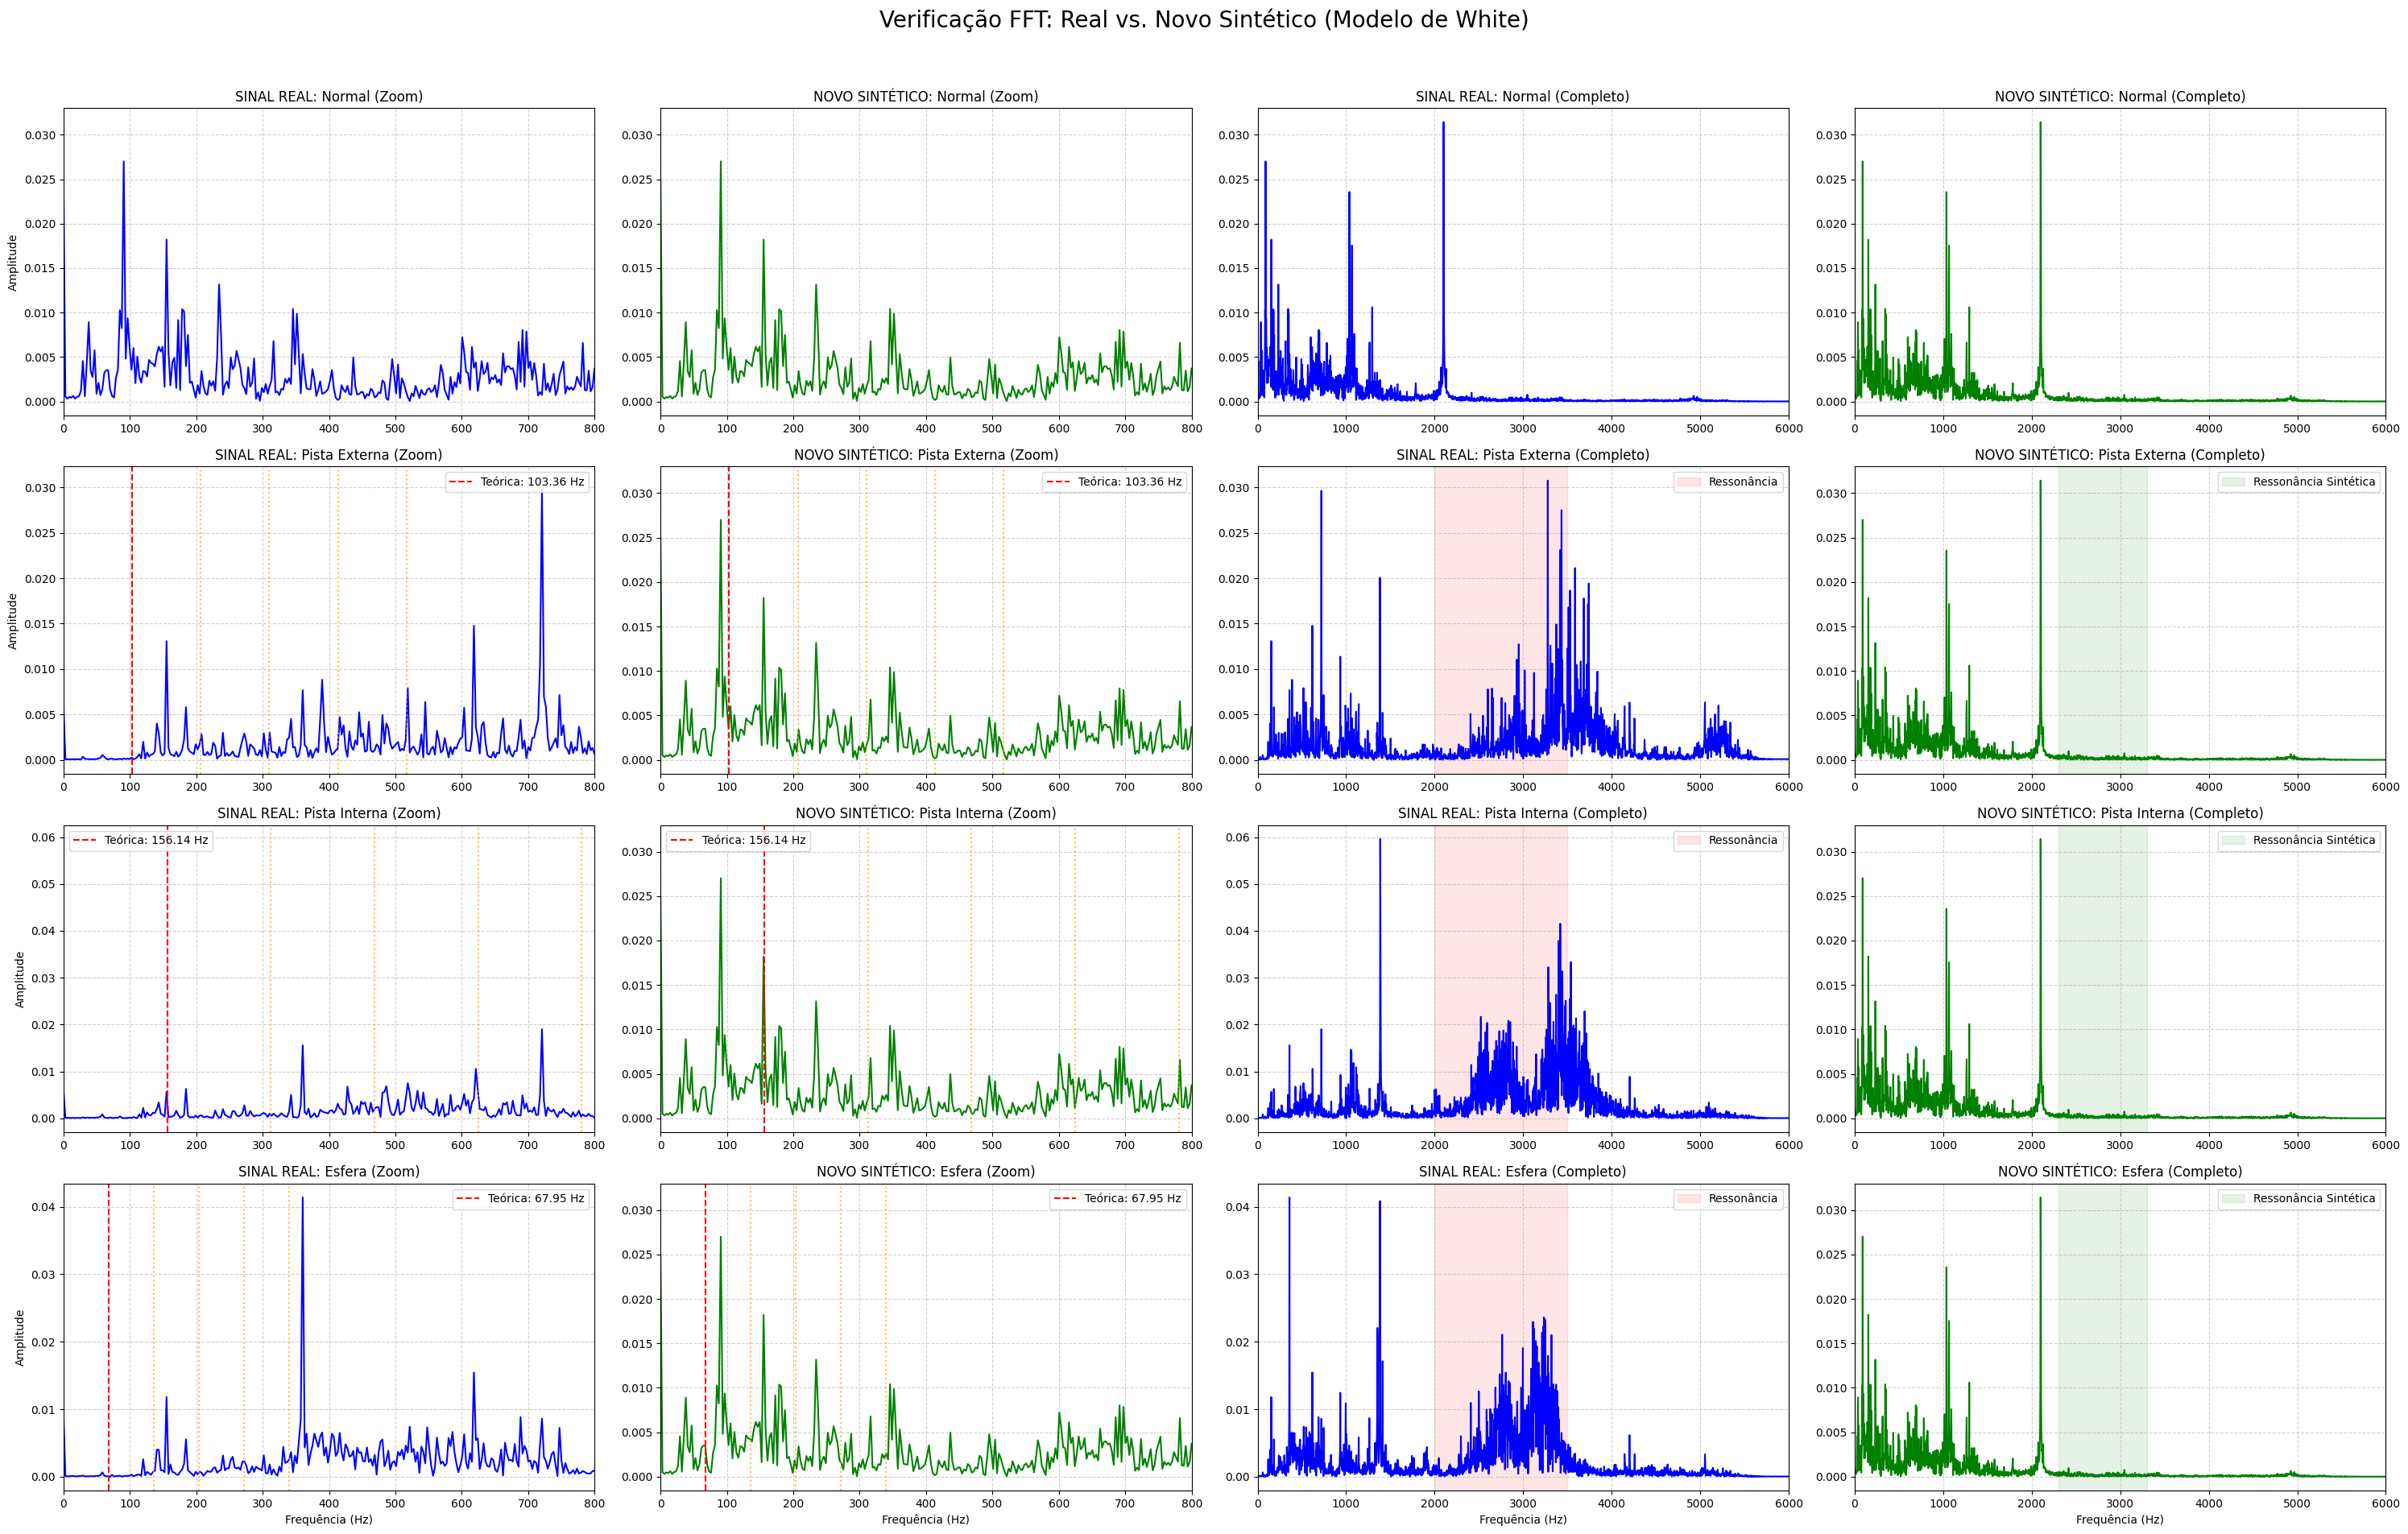

In [13]:
import matplotlib.pyplot as plt
import numpy as np

print("--- VERIFICAÇÃO FFT: SINAL REAL vs. NOVO SINAL SINTÉTICO (Modelo de White) ---")

# --- 1. CONFIGURAÇÕES ---
classes_para_plotar = ['Normal', 'Pista Externa', 'Pista Interna', 'Esfera']
XLIM_ZOOM = 800  # 0-800 Hz para ver harmônicos de falha
XLIM_FULL = TAXA_AMOSTRAL / 2 # 0-6000 Hz

# Criar a grade de plots: 4 linhas (classes), 4 colunas
# Col 0: Real (Zoom), Col 1: Sintético (Zoom), Col 2: Real (Full), Col 3: Sintético (Full)
fig, ax = plt.subplots(len(classes_para_plotar), 4, figsize=(30, 20)) # Figura mais larga
fig.suptitle('Verificação FFT: Real vs. Novo Sintético (Modelo de White)', fontsize=20)

# --- 2. FUNÇÕES AUXILIARES (copiadas para a célula ser independente) ---
def encontrar_primeiro_segmento_real(tipo_falha):
    dicionario_fonte = dicionario_treino if tipo_falha == 'Normal' else dicionario_teste
    for df_seg in dicionario_fonte.values():
        if df_seg['tipo_falha'].iloc[0] == tipo_falha:
            return df_seg['amplitude'].values, df_seg['rotacao_rpm'].iloc[0]
    return None, None

def encontrar_primeiro_segmento_sintetico(tipo_falha):
    query_str = f"tipo_falha_adicionada == '{tipo_falha}'"
    query_sintetico = df_sinais_treino.query(query_str)
    if not query_sintetico.empty:
        amostra = query_sintetico.iloc[0]
        return amostra['sinal_final'], amostra['rpm']
    return None, None

# --- 3. LOOP DE PLOTAGEM ---
try:
    for i, tipo_falha in enumerate(classes_para_plotar):
        
        # --- Configura os 4 eixos para esta linha ---
        ax_real_zoom = ax[i, 0]
        ax_sint_zoom = ax[i, 1]
        ax_real_full = ax[i, 2]
        ax_sint_full = ax[i, 3]

        # --- A. DADOS DO SINAL REAL ---
        sinal_real, rpm_real = encontrar_primeiro_segmento_real(tipo_falha)
        freq_teorica = None
        
        if sinal_real is not None:
            # Calcula FFT Real
            N_real = len(sinal_real)
            espectro_real = np.abs(np.fft.fft(sinal_real)[0:N_real//2]) / (N_real/2)
            freqs_real = np.fft.fftfreq(N_real, 1 / TAXA_AMOSTRAL)[:N_real//2]
            
            if tipo_falha != 'Normal':
                fr_hz_real = rpm_real / 60
                freq_teorica = calcular_frequencias_rolamento(fr=fr_hz_real, **params_drive_end)[tipo_falha]

            # PLOT 0: REAL (ZOOM)
            ax_real_zoom.plot(freqs_real, espectro_real, color='blue')
            ax_real_zoom.set_title(f'SINAL REAL: {tipo_falha} (Zoom)')
            ax_real_zoom.set_ylabel('Amplitude')
            ax_real_zoom.set_xlim(0, XLIM_ZOOM)
            ax_real_zoom.grid(True, linestyle='--', alpha=0.6)

            # PLOT 2: REAL (COMPLETO)
            ax_real_full.plot(freqs_real, espectro_real, color='blue')
            ax_real_full.set_title(f'SINAL REAL: {tipo_falha} (Completo)')
            ax_real_full.set_xlim(0, XLIM_FULL)
            ax_real_full.grid(True, linestyle='--', alpha=0.6)
            
            if tipo_falha != 'Normal':
                ax_real_full.axvspan(2000, 3500, color='red', alpha=0.1, label='Ressonância')
                ax_real_full.legend()
        else:
            ax_real_zoom.set_title(f"SINAL REAL '{tipo_falha}' NÃO ENCONTRADO")
            ax_real_full.set_title(f"SINAL REAL '{tipo_falha}' NÃO ENCONTRADO")

        # --- B. DADOS DO NOVO SINAL SINTÉTICO ---
        sinal_sint, rpm_sint = encontrar_primeiro_segmento_sintetico(tipo_falha)
        
        if sinal_sint is not None:
            # Calcula FFT Sintético
            N_sint = len(sinal_sint)
            espectro_sint = np.abs(np.fft.fft(sinal_sint)[0:N_sint//2]) / (N_sint/2)
            freqs_sint = np.fft.fftfreq(N_sint, 1 / TAXA_AMOSTRAL)[:N_sint//2]

            # PLOT 1: SINTÉTICO (ZOOM)
            ax_sint_zoom.plot(freqs_sint, espectro_sint, color='green')
            ax_sint_zoom.set_title(f'NOVO SINTÉTICO: {tipo_falha} (Zoom)')
            ax_sint_zoom.set_xlim(0, XLIM_ZOOM)
            ax_sint_zoom.grid(True, linestyle='--', alpha=0.6)

            # PLOT 3: SINTÉTICO (COMPLETO)
            ax_sint_full.plot(freqs_sint, espectro_sint, color='green')
            ax_sint_full.set_title(f'NOVO SINTÉTICO: {tipo_falha} (Completo)')
            ax_sint_full.set_xlim(0, XLIM_FULL)
            ax_sint_full.grid(True, linestyle='--', alpha=0.6)

            # --- C. Adiciona linhas teóricas (se for falha) ---
            if freq_teorica:
                # Linhas no Real (Zoom)
                ax_real_zoom.axvline(x=freq_teorica, color='red', linestyle='--', label=f'Teórica: {freq_teorica:.2f} Hz')
                for h in range(2, 6): ax_real_zoom.axvline(x=freq_teorica * h, color='orange', linestyle=':', alpha=0.7)
                ax_real_zoom.legend()
                
                # Linhas no Sintético (Zoom)
                # (O trem de impulsos + convolução GERA harmônicos, então vamos marcá-los)
                ax_sint_zoom.axvline(x=freq_teorica, color='red', linestyle='--', label=f'Teórica: {freq_teorica:.2f} Hz')
                for h in range(2, 6): ax_sint_zoom.axvline(x=freq_teorica * h, color='orange', linestyle=':', alpha=0.7)
                ax_sint_zoom.legend()

            # Adiciona a "montanha" de ressonância esperada no plot sintético
            if tipo_falha != 'Normal':
                ax_sint_full.axvspan(freq_natural_hz - 500, freq_natural_hz + 500, color='green', alpha=0.1, label='Ressonância Sintética')
                ax_sint_full.legend()
        else:
            ax_sint_zoom.set_title(f"SINTÉTICO '{tipo_falha}' NÃO ENCONTRADO")
            ax_sint_full.set_title(f"SINTÉTICO '{tipo_falha}' NÃO ENCONTRADO")

        # Adiciona xlabel na última linha
        if i == len(classes_para_plotar) - 1:
            ax_real_zoom.set_xlabel('Frequência (Hz)')
            ax_sint_zoom.set_xlabel('Frequência (Hz)')
            ax_real_full.set_xlabel('Frequência (Hz)')
            ax_sint_full.set_xlabel('Frequência (Hz)')

    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

except NameError as e:
    print(f"\nERRO: Variável não encontrada ({e}).")
    print("Certifique-se de ter executado o Bloco 1 e o Bloco 2 (o novo) primeiro.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import skew

# =============================================================================
# BLOCO 3: EXTRAÇÃO DE FEATURES E CRIAÇÃO DOS DATAFRAMES FINAIS (ATUALIZADO)
# =============================================================================

# --- 1. FUNÇÕES PARA CÁLCULO DOS ATRIBUTOS ---

# --- DOMÍNIO DO TEMPO ---
def calcular_tf2_std(sinal):
    return np.std(sinal)

def calcular_tf3_rms(sinal):
    return np.sqrt(np.mean(sinal**2))

def calcular_tf4_fator_forma(sinal):
    rms = calcular_tf3_rms(sinal)
    media_abs = np.mean(np.abs(sinal))
    return rms / media_abs if media_abs != 0 else 0

# --- DOMÍNIO DA FREQUÊNCIA ---
def calcular_features_frequencia(sinal, taxa_amostral):
    N = len(sinal)
    if N == 0: return 0, 0, 0
    espectro = np.abs(np.fft.fft(sinal)[0:N//2])
    freqs = np.fft.fftfreq(N, 1 / taxa_amostral)[:N//2]
    soma_espectro = np.sum(espectro)
    if soma_espectro == 0: return 0, 0, 0
    ff2_freq_central = np.sum(freqs * espectro) / soma_espectro
    ff3_rms_freq = np.sqrt(np.sum((freqs**2) * espectro) / soma_espectro)
    ff4_std_freq = np.sqrt(np.sum(((freqs - ff2_freq_central)**2) * espectro) / soma_espectro)
    numerador_ff5 = np.sum(((freqs - ff2_freq_central)**3) * espectro) / soma_espectro
    ff5_assimetria = numerador_ff5 / (ff4_std_freq**3) if ff4_std_freq != 0 else 0
    return ff2_freq_central, ff3_rms_freq, ff5_assimetria

# ******************************************************************************
# *** NOVA FUNÇÃO ADICIONADA AQUI ***
def calcular_freq_pico_range(sinal, taxa_amostral, min_freq=50, max_freq=200):
    """Calcula a frequência com a maior amplitude (pico) em um range específico."""
    N = len(sinal)
    if N == 0:
        return 0

    # Calcula a FFT e as frequências correspondentes
    espectro = np.abs(np.fft.fft(sinal)[0:N//2])
    freqs = np.fft.fftfreq(N, 1 / taxa_amostral)[:N//2]

    # Cria uma máscara booleana para o range de frequência desejado
    range_mask = (freqs >= min_freq) & (freqs <= max_freq)

    # Filtra as frequências e o espectro para o range de interesse
    freqs_filtradas = freqs[range_mask]
    espectro_filtrado = espectro[range_mask]

    # Verifica se existe algum valor no espectro filtrado
    if len(espectro_filtrado) == 0:
        return 0 # Retorna 0 se não houver componentes de frequência no range

    # Encontra o índice do pico (valor máximo) no espectro filtrado
    indice_pico = np.argmax(espectro_filtrado)

    # Retorna a frequência correspondente a esse pico
    freq_pico = freqs_filtradas[indice_pico]

    return freq_pico
# ******************************************************************************


# --- FUNÇÃO PRINCIPAL DE EXTRAÇÃO (ATUALIZADA) ---
def extrair_todas_features(sinal, taxa_amostral):
    # Features anteriores
    tf2 = calcular_tf2_std(sinal)
    tf3 = calcular_tf3_rms(sinal)
    tf4 = calcular_tf4_fator_forma(sinal)
    ff2, ff3, ff5 = calcular_features_frequencia(sinal, taxa_amostral)

    # *** CÁLCULO DA NOVA FEATURE ***
    ff_pico_range = calcular_freq_pico_range(sinal, taxa_amostral, min_freq=50, max_freq=200)

    # Retorna o dicionário com a nova feature incluída
    return {
        'TF2_std': tf2, 'TF3_rms': tf3, 'TF4_fator_forma': tf4,
        'FF2_freq_central': ff2, 'FF3_rms_freq': ff3, 'FF5_assimetria_espectral': ff5,
        'FF_pico_50_200Hz': ff_pico_range # *** NOVA FEATURE ADICIONADA AQUI ***
    }


# =============================================================================
# --- 2. PROCESSAMENTO DO CONJUNTO DE TREINO (O CÓDIGO AQUI NÃO MUDA) ---
# =============================================================================
print("--- Iniciando extração de atributos do conjunto de TREINO ---")
lista_de_features_treino = []
for linha in df_sinais_treino.itertuples():
    features = extrair_todas_features(linha.sinal_final, TAXA_AMOSTRAL)
    features['tipo_falha_adicionada'] = linha.tipo_falha_adicionada
    features['rpm'] = linha.rpm
    features['multiplicador_amplitude'] = linha.multiplicador_amplitude
    features['fase_adicionada_rad'] = linha.fase_adicionada_rad
    features['base_normal'] = linha.base_normal
    lista_de_features_treino.append(features)

df_treino = pd.DataFrame(lista_de_features_treino)
print(f"Extração concluída! {len(df_treino)} amostras no df_treino.")

# =============================================================================
# --- 3. PROCESSAMENTO DO CONJUNTO DE TESTE (O CÓDIGO AQUI NÃO MUDA) ---
# =============================================================================
print("\n--- Iniciando extração de atributos do conjunto de TESTE ---")
lista_de_features_teste = []
for chave, df_segmento in dicionario_teste.items():
    sinal = df_segmento['amplitude'].values
    features = extrair_todas_features(sinal, TAXA_AMOSTRAL)
    features['tipo_falha_adicionada'] = df_segmento['tipo_falha'].iloc[0]
    features['rpm'] = df_segmento['rotacao_rpm'].iloc[0]
    features['arquivo_origem'] = df_segmento['arquivo_origem'].iloc[0]
    lista_de_features_teste.append(features)

df_teste = pd.DataFrame(lista_de_features_teste)
print(f"Extração concluída! {len(df_teste)} amostras no df_teste.")

# --- 4. EXIBIÇÃO DOS RESULTADOS ---
print("\n\n--- AMOSTRA DO df_treino (DADOS TRATADOS PARA TREINAMENTO) ---")
print(df_treino.head())
print("\n--- INFORMAÇÕES DO df_treino ---")
df_treino.info()

print("\n\n--- AMOSTRA DO df_teste (DADOS TRATADOS PARA TESTE) ---")
print(df_teste.head())
print("\n--- INFORMAÇÕES DO df_teste ---")
df_teste.info()

--- Iniciando extração de atributos do conjunto de TREINO ---
Extração concluída! 17390 amostras no df_treino.

--- Iniciando extração de atributos do conjunto de TESTE ---
Extração concluída! 2897 amostras no df_teste.


--- AMOSTRA DO df_treino (DADOS TRATADOS PARA TREINAMENTO) ---
    TF2_std   TF3_rms  TF4_fator_forma  FF2_freq_central  FF3_rms_freq  \
0  0.065466  0.066641         1.241618       1098.045652   1513.799469   
1  0.065466  0.066640         1.241613       1098.046186   1513.786506   
2  0.065466  0.066641         1.241617       1098.047071   1513.789236   
3  0.065466  0.066641         1.241613       1098.039623   1513.787826   
4  0.065466  0.066641         1.241619       1098.023064   1513.813544   

   FF5_assimetria_espectral  FF_pico_50_200Hz tipo_falha_adicionada   rpm  \
0                  1.737948         90.820312         Pista Externa  1730   
1                  1.737799         90.820312         Pista Externa  1730   
2                  1.737817         90.

In [12]:
# =============================================================================
# BLOCO 4: SALVAR OS DATAFRAMES FINAIS EM CSV (COM CAMINHO ESPECÍFICO)
# =============================================================================

import os

# Caminho de saída EXATO fornecido por você
caminho_base_output = r'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC'

# Cria o diretório se ele não existir
if not os.path.exists(caminho_base_output):
    os.makedirs(caminho_base_output)
    print(f"Diretório criado em: {caminho_base_output}")

# Define os nomes dos arquivos
caminho_csv_treino = os.path.join(caminho_base_output, 'df_treino_features.csv')
caminho_csv_teste = os.path.join(caminho_base_output, 'df_teste_features.csv')

try:
    # Salva o DataFrame de treino
    df_treino.to_csv(caminho_csv_treino, index=False)
    print(f"\nDataFrame de TREINO (features) salvo com sucesso em:")
    print(f"{caminho_csv_treino}")

    # Salva o DataFrame de teste
    df_teste.to_csv(caminho_csv_teste, index=False)
    print(f"\nDataFrame de TESTE (features) salvo com sucesso em:")
    print(f"{caminho_csv_teste}")

except NameError:
    print("\nERRO: Os DataFrames 'df_treino' ou 'df_teste' não foram encontrados.")
    print("Certifique-se de que o Bloco 3 foi executado com sucesso antes de salvar.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado ao salvar os arquivos: {e}")


DataFrame de TREINO (features) salvo com sucesso em:
C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC\df_treino_features.csv

DataFrame de TESTE (features) salvo com sucesso em:
C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC\df_teste_features.csv
